# Analysis functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from src.utilities import time_to_seconds, get_triplicates_jackknife, get_endpoint, get_initial
from src.modeling import model_one_step, model_occlusion, residuals, fit_model
from src.statistics import wald_z, ztest_ratio, holm_correction, prop_err_division
#Standardized color scheme for plotting
color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Single step, mechanistic

## Importing data

In [2]:
data_dir = "Data/"
UW_backgr = pd.read_csv(data_dir + "UW_backgr.csv")
conditions_UW_backgr = {'R alone' : ['B2', 'C2', 'D2'],
'N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B3', 'C3', 'D3'],
'R(nn) alone' : ['E2', 'F2', 'G2'],
'N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E3', 'F3', 'G3']}
offset_UW_backgr = 0
t_UW_backgr = [time_to_seconds(i) for i in list(UW_backgr['Time'].values)]
UW_trig = pd.read_csv(data_dir + "UW_trig.csv")
conditions_UW_trig = {'R background' : ['E9', 'F9', 'G9'],
              'no background nat' : ['E13', 'F13', 'G13'],
              'Trig N50_25uM nat' : ['E11', 'F11', 'G11'],
              'R(nn) background' : ['H9', 'I9', 'J9'],
              'no background nn' : ['H13', 'I13', 'J13'],
              'Trig N50_25uM nn' : ['H11', 'I11', 'J11']}
offset_UW_trig = 140
t_UW_trig = [time_to_seconds(i) for i in list(UW_trig['Time'].values)]


UW_rep = pd.read_csv(data_dir + "UW_rep.csv")
conditions_UW_rep = {'R background' : ['E8', 'F8', 'G8'],
              'no background nat' : ['E12', 'F12', 'G12'],
              'Rep N50_25uM nat' : ['E10', 'F10', 'G10'],
              'R(nn) background' : ['H8', 'I8', 'J8'],
              'no background nn' : ['H12', 'I12', 'J12'],
              'Rep N50_25uM nn' : ['H10', 'I10', 'J10']}
offset_UW_rep = 140
t_UW_rep = [time_to_seconds(i) for i in list(UW_rep['Time'].values)]


UW_no = pd.read_csv(data_dir + "UW_no.csv")
conditions_UW_no = {'no background nat' : ['E3', 'F3', 'G3'],
'R background' : ['E4', 'F4', 'G4'],
'No N50_25uM nat' : ['E5', 'F5', 'G5'],
'no background nn' : ['H3', 'I3', 'J3'],
'R(nn) background' : ['H4', 'I4', 'J4'],
'No N50_25uM nn' : ['H5', 'I5', 'J5']}
offset_UW_no = 140
t_UW_no = [time_to_seconds(i) for i in list(UW_no['Time'].values)]


TUM_controls = pd.read_csv(data_dir + "TUM_controls.csv")
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3'],
                          'no background nat' : ['OneStep_1',	'OneStep_2',	'OneStep_3'],
                          'no background nn' : ['OneStep(nn)_1',	'OneStep(nn)_2',	'OneStep(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) for t in TUM_controls['time'].values]

TUM_no = pd.read_csv(data_dir + "TUM_no.csv")
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) for t in TUM_no['time'].values]

TUM_trig = pd.read_csv(data_dir + "TUM_trig.csv")
conditions_TUM_trig = {'Trig inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Trig inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Trig inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Trig inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Trig inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Trig inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Trig inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Trig inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_trig = 0
t_TUM_trig = [int(t) for t in TUM_trig['time'].values]


TUM_rep = pd.read_csv(data_dir + "TUM_rep.csv")
conditions_TUM_rep = {'Rep inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Rep inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Rep inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Rep inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Rep inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Rep inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Rep inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Rep inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_rep = 0
t_TUM_rep = [int(t) for t in TUM_rep['time'].values]

# Control fits TUM

In [3]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]
number_of_points = 6*3600//60

Fitted kf = 7.6e+03 ± 7.6e+02 (jackknife SE, n=3)
RMSE = 5.238e-01
nRMSE (normed by mean)  = 0.033


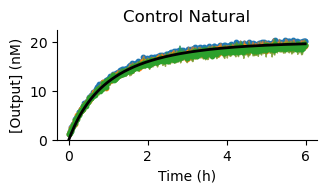

In [4]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])



format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for level in levels:
    curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
    stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_h = [i / 3600 for i in x]
x_th = [i / 3600 for i in x_trunc]





# Initial parameters
y_init = [
  0.0,  # Initial concentration of P   (0)
  20.0,  # Initial concentration of Y1  (1)
  0.0,  # Initial concentration of W   (2)
]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nat = [[kf_mean, kf_se]]
fitted_kf = k_control_nat[0][0]

# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([i for i in rep])-np.array(stdDev[0][i])),np.array([i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[i for i in rep],  (np.array([i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")





ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


plt.show()



Fitted kf = 2.2e+04 ± 1.1e+03 (jackknife SE, n=3)
RMSE = 4.159e-01
nRMSE (normed by mean)  = 0.023


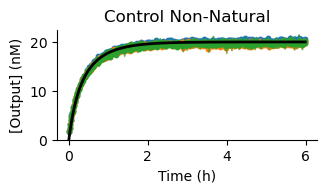

In [5]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])



format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for level in levels:
    curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
    stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_h = [i / 3600 for i in x]
x_th = [i / 3600 for i in x_trunc]





# Initial parameters
y_init = [
  0.0,  # Initial concentration of P   (0)
  20.0,  # Initial concentration of Y1  (1)
  0.0,  # Initial concentration of W   (2)
]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nn = [[kf_mean, kf_se]]
fitted_kf = k_control_nn[0][0]

# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([i for i in rep])-np.array(stdDev[0][i])),np.array([i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[i for i in rep],  (np.array([i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")





ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


plt.show()



### TUM No incubations

#### Nat

Fitted kr_s = 5.8e+01 ± 6.8e+00 (jackknife SE)
RMSE = 3.669e-01
nRMSE (normed by mean)  = 0.033
Fitted kr_s = 4.4e+01 ± 3.7e+00 (jackknife SE)
RMSE = 4.897e-01
nRMSE (normed by mean)  = 0.072
Fitted kr_s = 4.0e+00 ± 6.1e-01 (jackknife SE)
RMSE = 4.066e-01
nRMSE (normed by mean)  = 0.172
Fitted kr_s = 3.8e+00 ± 2.6e-01 (jackknife SE)
RMSE = 2.339e-01
nRMSE (normed by mean)  = 0.226


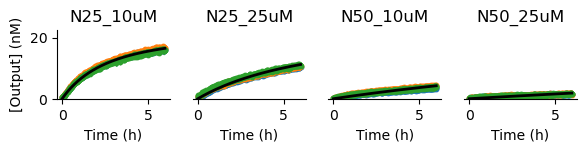

In [6]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



B_concs = [10000, 25000, 10000, 25000]
# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nat[0][0]

fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [0, 0, 0, 0]

x_list  = [x_trunc]



fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


kb_no_nat = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    

    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [e for e in curve]
        r = fit_model(model_occlusion, x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)



    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kr_s = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se
    kb_no_nat.append([fitted_kf, param_sd_kf])

    a.plot(x_h,[i for i in model_occlusion(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = fixed_params_list[i]
    r = residuals(kf_mean, model_occlusion,  t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_multi_nat.svg', dpi = 500, transparent=True)
plt.show()



In [7]:
def kb_to_e(kb, e_kb):
    RT = 0.592
    f = -RT*np.log(1e7/kb)
    dfit = (-1e7/(kb**2))*(-RT*(1/(1e7/kb)))
    df = np.sqrt((dfit*e_kb)**2)
    return f, df

for fit in kb_no_nat:
    e, s = kb_to_e(fit[0], fit[1])
    print(f"{e:.3f} +/- {s:.3f}")


-7.134 +/- 0.069
-7.298 +/- 0.050
-8.722 +/- 0.091
-8.747 +/- 0.040


#### NN

Fitted kr_s = 6.9e+01 ± 6.9e+00 (jackknife SE)
RMSE = 3.777e-01
nRMSE (normed by mean)  = 0.023
Fitted kr_s = 6.9e+01 ± 4.9e+00 (jackknife SE)
RMSE = 4.463e-01
nRMSE (normed by mean)  = 0.032
Fitted kr_s = 1.0e+01 ± 1.5e+00 (jackknife SE)
RMSE = 9.353e-01
nRMSE (normed by mean)  = 0.095
Fitted kr_s = 6.8e+00 ± 3.9e-01 (jackknife SE)
RMSE = 4.424e-01
nRMSE (normed by mean)  = 0.105


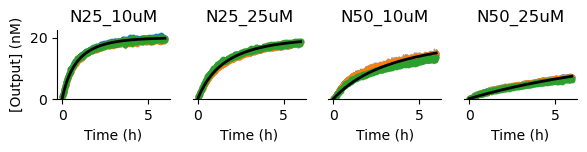

In [8]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


B_concs = [10000, 25000, 10000, 25000]

# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nn[0][0]
fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [50, 50, 0, 0]

x_list  = [x_trunc]




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


kb_no_nn = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    

    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [e for e in curve]
        r = fit_model(model_occlusion, x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)



    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kr_s = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se
    kb_no_nn.append([fitted_kf, param_sd_kf])

    a.plot(x_h,[i for i in model_occlusion(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = fixed_params_list[i]
    r = residuals(kf_mean, model_occlusion, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)

ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_multi_nn.svg', dpi = 500, transparent=True)
plt.show()


In [20]:
def kb_to_e(kb, e_kb):
    RT = 0.592
    f = -RT*np.log(1e7/kb)
    dfit = (-1e7/(kb**2))*(-RT*(1/(1e7/kb)))
    df = np.sqrt((dfit*e_kb)**2)
    return f, df

for fit in kb_no_nat:
    e, s = kb_to_e(fit[0], fit[1])
    print(f"{e:.3f} +/- {s:.3f}")


-7.134 +/- 0.069
-7.298 +/- 0.050
-8.722 +/- 0.091
-8.747 +/- 0.040


# Summary graphic

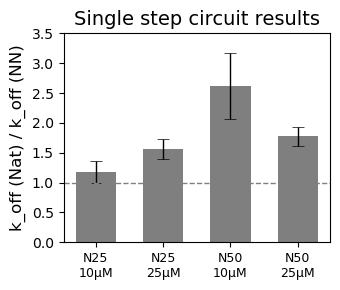


=== Wald tests: ratio vs 1 for each bar ===
One-step,N25_10μM: ratio=1.179 ± 0.181, Z=0.989, p=3.227e-01, p_holm=3.227e-01
One-step,N25_25μM: ratio=1.561 ± 0.172, Z=3.269, p=1.081e-03, p_holm=3.243e-03
One-step,N50_10μM: ratio=2.617 ± 0.553, Z=2.922, p=3.475e-03, p_holm=6.951e-03
One-step,N50_25μM: ratio=1.777 ± 0.156, Z=4.967, p=6.793e-07, p_holm=2.717e-06

=== Omnibus test: all bars combined ===
Combined Z = 5.907, omnibus p = 3.487e-09


In [9]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['One-step']
colors = [color_scheme[7]]
bar_width = 0.6



# Prepare experimental data
no = [kb_no_nat, kb_no_nn]
systems = [no]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_group = np.arange(n_groups) # center position for each group
x_offsets = [0]  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)



# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = list(x_group)
x_labels =  group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('k_off (Nat) / k_off (NN)', fontsize=12)
ax.set_ylim(0, 3.5)
ax.set_title('Single step circuit results', fontsize=14)

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("Figures/Two-step_results.svg", dpi=400)
plt.show()


# Per-bar Wald Z-tests with Holm correction
pvals = []
tests = []

print("\n=== Wald tests: ratio vs 1 for each bar ===")

for i in range(n_conditions):
    for j in range(n_groups):
        r  = fold[i][j]
        se = e_fold[i][j]
        Z, p = ztest_ratio(r, se)
        pvals.append(p)
        tests.append((conditions[i], group_labels[j].replace("\n", "_"), r, se, Z, p))

# Apply Holm
p_adj = holm_correction(pvals)

for (cond, grp, r, se, Z, p_raw), p_corr in zip(tests, p_adj):
    print(f"{cond},{grp}: ratio={r:.3f} ± {se:.3f}, "
          f"Z={Z:.3f}, p={p_raw:.3e}, p_holm={p_corr:.3e}")


# Omnibus test across all four one-step bars
# (inverse-variance–weighted Z test)
print("\n=== Omnibus test: all bars combined ===")

ratios = fold[0]
ses    = e_fold[0]

# Weighted Z-statistic
weights = 1 / (ses**2)
Z_num = np.sum(weights * (ratios - 1))
Z_den = np.sqrt(np.sum(weights))
Z_comb = Z_num / Z_den
p_comb = 2 * (1 - norm.cdf(abs(Z_comb)))

print(f"Combined Z = {Z_comb:.3f}, omnibus p = {p_comb:.3e}")


